# Imports

In [1]:
from utils import *
from paths_and_parameters import *
first_n_peaks = 5

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for path_sel in [path_figures, path_results, path_database_exp]:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in [path_figures, path_results, path_database_exp]:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read XRD Data and Database
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [4]:
%matplotlib inline
rcParams['font.size'] = 12

try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)

y_x_ratio = data.shape[0] / data.shape[1]
print(f'Shape of data: {data.shape}')
print('Initial calibration:')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

database = DatabaseXRD().read_cifs(path_database)
print('\nPhases in database:', len(database))

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
Initial calibration:
a = -1214.7, s = 1952.7, beta = 51.663
Theta range [19.77907407899562, 53.578190550653794]

Phases in database: 365


### Correct burnt pixels
Substitute burnt pixel with the average of the non burnt ones.

In [5]:
qtl = 0.999

data_max = (data.data - data.background).max(axis = 2)
indices_to_correct = data_max > quantile(data_max, qtl)

data.data[indices_to_correct] = data.data[~indices_to_correct].mean(axis = 0, keepdims = True)
data.background[indices_to_correct] = data.background[~indices_to_correct].mean(axis = 0, keepdims = True)
data.intensity[indices_to_correct] = data.intensity[~indices_to_correct].mean(axis = 0, keepdims = True)
data.signal_background_ratio[indices_to_correct] = data.signal_background_ratio[~indices_to_correct].mean(axis = 0, keepdims = True)
data.rescaling[indices_to_correct] = data.rescaling[~indices_to_correct].mean(axis = 0, keepdims = True)

print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} were corrected.')

17 pixels out of 16150 were corrected.


# Read XRF maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [6]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = xrf_axes_flip)
y_x_ratio = data_xrf.labels.shape[0] / data_xrf.labels.shape[1]
print(f'Found {data_xrf.labels.shape[2]} images:')
print(', '.join([name for name in data_xrf.metadata['labels']]))

Found 24 images:
Al_K, Ar_K, As_K, Ba_L, Ca_K, Cd_L, Cl_K, Co_K, Cr_K, Cu_Ka, Cu_Kb, Fe_K, Hg_L, K_K, Mn_K, P_K, Pb_L, Pb_M, S_K, Se_K, Si_K, Sn_L, Ti_K, Zn_K


### Correct burnt pixels and wrong scale in each XRF map; also calculate normalized XRF maps
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [7]:
qtl = 0.999
#qtl = 1

qtl_calculated = quantile(data_xrf.labels, qtl, axis = (0, 1), keepdims = True)
n_corrected = (data_xrf.labels > qtl_calculated).sum() / data_xrf.labels.shape[-1]
data_xrf.labels = clip(data_xrf.labels, None, qtl_calculated)
print(f'{n_corrected:.0f} pixels out of {data_xrf.labels.shape[0] * data_xrf.labels.shape[1]} were corrected on average in each XRF map.')

data_xrf.labels -= data_xrf.labels.min(axis = (0, 1), keepdims = True)

maps_xrf_norm = data_xrf.labels / data_xrf.labels.max(axis = (0, 1), keepdims = True)

17 pixels out of 16150 were corrected on average in each XRF map.


# Select primary phases

### Manually select them

In [8]:
P1= database['Hydrocerussite'][0]
P2 = database['Lazurite'][0]
P3 = database['Cinnabar'][0]
S1 = database['Metacinnabar'][1]
S3 = database['Sodalite'][20]
S4 = database['Barite'][0]
S5 = database['Goethite'][15]
S6 = database['Hematite'][9]

phases_primary = [P1, P2, P3, S5, S6]

### Take them from file `phases_selection_primary.dat`

In [11]:
phases_primary = phases_from_file('phases_selection_primary.dat', database)

Loaded phases: Goethite 14, Jarosite 15


# Search for primary phases

### Change initial calibration

In [12]:
#data.opt = array([-1208.08149362, 1948.24846333, 51.66346438])

### Create data structure

In [9]:
gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [10]:
%%time
gm = gm.search()
L1loss, MSEloss, overlap_area = gm.metrics()

Using 8 CPUs
Using 8 CPUs
CPU times: user 16.8 s, sys: 1.69 s, total: 18.5 s
Wall time: 22.5 s


#### Fast mapping

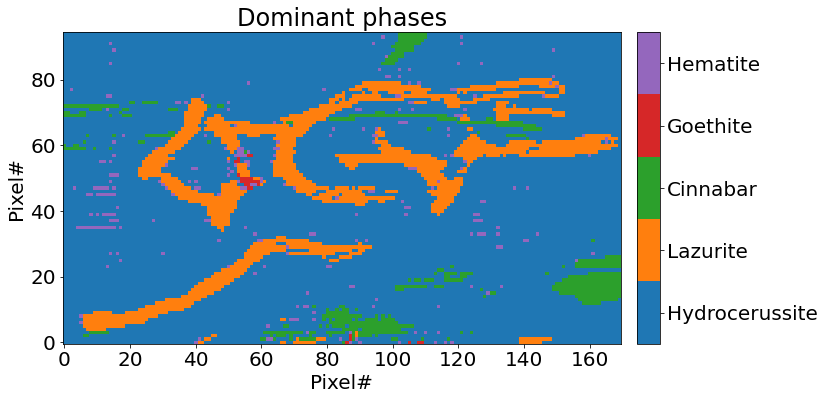

In [11]:
%matplotlib inline
rcParams['font.size'] = 20

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = imshow(gm.selected(), interpolation = 'none', cmap = cmap_chosen, norm = norm_chosen)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'fast_map_dominant_phases.png', bbox_inches = 'tight', dpi = 200)
show()

# Quantify phase presence

In [12]:
correction = data.rescaling**0.5
criterion = overlap_area * correction

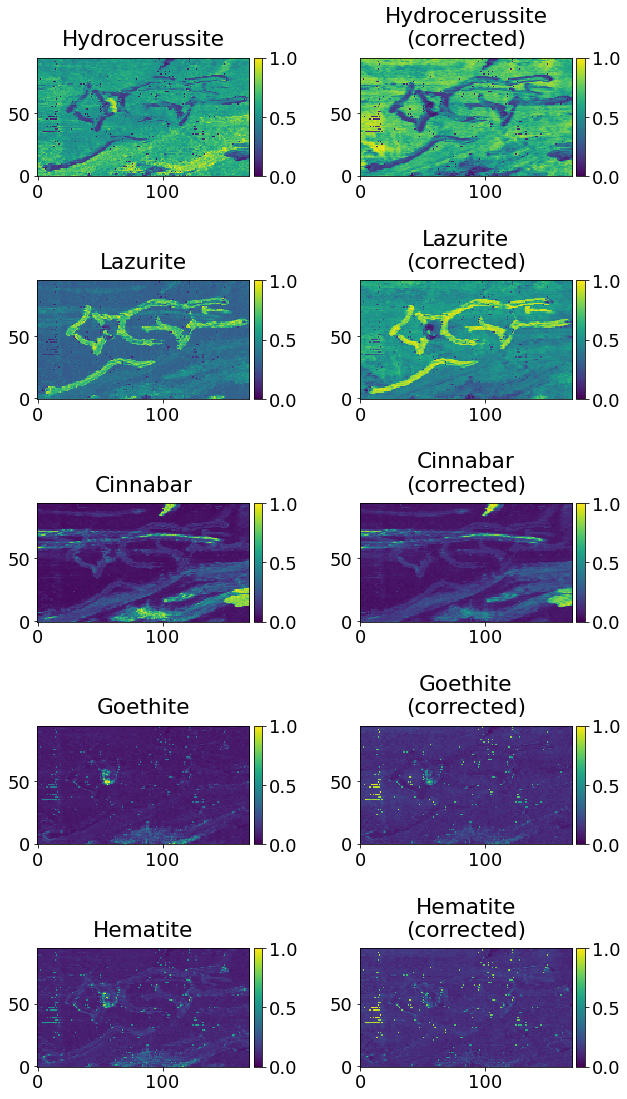

In [13]:
%matplotlib inline
rcParams['font.size'] = 18
position_colorbar = [1.02, 0, 0.04, 1]
include_xrf_filter = False

if include_xrf_filter:
    n_cols = 4
else:
    n_cols = 2
fig, axs = subplots(len(gm.phases), n_cols, figsize = (4.5 * n_cols, 3 * len(gm.phases)))
fig.tight_layout(h_pad = 4, w_pad = 2)

for i, phase in enumerate(gm.phases):
    if (len(gm.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    matrix_plot = overlap_area[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
    ax.set_title(phase.label, y = 1.05)
    
    if (len(gm.phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    matrix_plot = criterion[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
    ax.set_title(phase.label + '\n(corrected)', y = 1.05)
    
    if include_xrf_filter:
        indices_associated_elements = []
        if 'associated elements' in phase.keys():
            print(phase.label + ': ' + ', '.join(phase['associated elements']))
            for element in phase['associated elements']:
                j = find_element(element, data_xrf.metadata['labels'], allow_loose = False)
                if j is None:
                    print(phase.label + ': ' + phase['associated element'] + ' not found')
                else:
                    indices_associated_elements.append(j)
        if indices_associated_elements:        

            if (len(gm.phases) > 1):
                ax = axs[i, 2]
            else:
                ax = axs[2]
            map_xrf = data_xrf.labels[..., indices_associated_elements].min(axis = -1)
            im = ax.imshow(map_xrf, interpolation = 'none')
            formatter = ScalarFormatter(useMathText = True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-2, 2))
            cb = colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar), format = formatter)
            cb.ax.yaxis.set_offset_position('left')
            ax.set_title('\n'.join([data_xrf.metadata['labels'][idx] for idx in indices_associated_elements]), y = 1.05)

            if (len(gm.phases) > 1):
                ax = axs[i, 3]
            else:
                ax = axs[3]
            map_xrd = criterion[..., i] / criterion[..., i].max()
            map_xrf = map_xrf / map_xrf.max()
            map_xrd_corrected = map_xrd * map_xrf
            map_xrd_corrected /= map_xrd_corrected.max()
            im = ax.imshow(map_xrd_corrected, interpolation = 'none', vmin = 0)
            colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
            ax.set_title(phase.label + '\n(corrected and filtered)', y = 1.05)

show()

### Save maps as PNG and TIF

In [18]:
rcParams['font.size'] = 14

matrices_base = [overlap_area, criterion]
string_added = ['', ' (corrected)']

for i in [0, 1]:
    matrix_base = matrices_base[i]
    value_max = nanmax(nanmax(matrix_base, axis = 0, keepdims = True), axis = 1, keepdims = True)
    matrix_plot = matrix_base / value_max
    matrix_components_tiff = flip((matrix_plot * 65535).astype('uint16'), axis = [0])

    for idx_phase, phase in enumerate(gm.phases):
        fig, ax = subplots(figsize = (5, 3))
        im = imshow(matrix_plot[..., idx_phase], interpolation = 'none', vmin = 0)
        colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(phase.label)
        fig.set_dpi(80)
        savefig(path_figures + 'primary - ' + phase.label + ' - presence' + string_added[i] + '.png',
                    bbox_inches = 'tight', dpi = 600)

        img = Image.fromarray(matrix_components_tiff[..., idx_phase])
        img.save(path_results + 'primary - ' + phase.label + ' - presence BW' + string_added[i] + '.tiff')
        img.save(path_figures + 'primary - ' + phase.label + ' - presence BW' + string_added[i] + '.png')

        close(fig)

# Explore one pixel with fitted primary phases
- You can select phases that have all the given elements
- The pixel to analyse can be selected manually, or automatically from XRF map, or automatically from phase presence

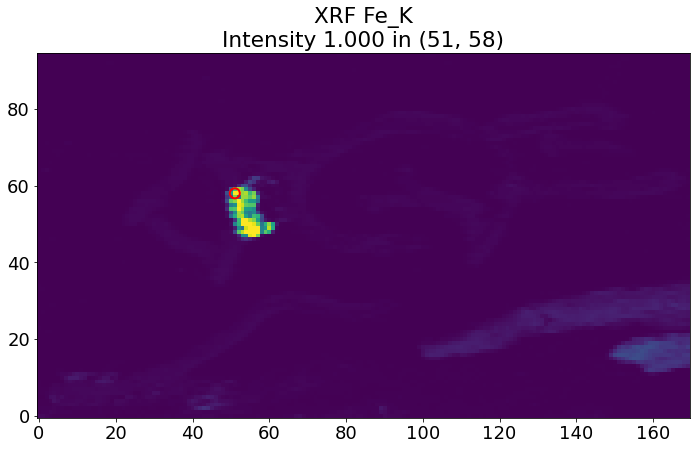

,XRF element,XRF intensity,Phase,Phase presece,Phase overlap,"(x, y)"
0,Fe_K,1.000,Goethite,0.173,0.098,"(51, 58)"
1,Fe_K,1.000,Hematite,0.457,0.198,"(51, 58)"


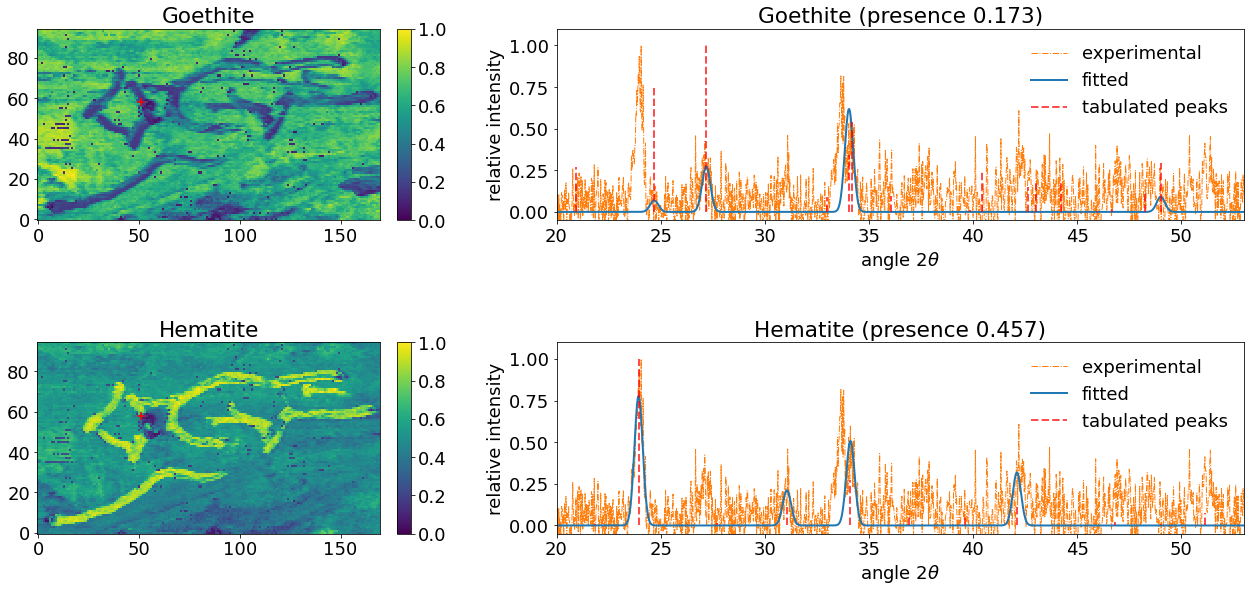

In [19]:
rcParams['font.size'] = 18

elements_chosen = ['Fe'] # Only phases with these elements will be selected

#selection_of_x_y = 'manual'               # Manually select the pixel
selection_of_x_y = 'from XRF'             # Automatically select the pixel in which the first element chosen has maximum XRF intensity
#selection_of_x_y = 'from phase presence'  # Automatically select for each phase the pixel in which the phase has maximum presence
n_th_best_pixel = 10

x, y = 20, 40

phases_sel = []
for i, phase in enumerate(gm.phases):
    if '_chemical_formula_sum' in phase:
        if all(e in phase['_chemical_formula_sum'] for e in elements_chosen):
            phases_sel.append(phase)

i_element = find_element(elements_chosen[0], data_xrf.metadata['labels'])
map_xrf = maps_xrf_norm[..., i_element]
presence_max = nanmax(nanmax(criterion, axis = 0, keepdims = True), axis = 1, keepdims = True)
maps_phase_presence = criterion / presence_max

df_stats = DataFrame(columns = ['XRF element', 'XRF intensity', 'Phase', 'Phase presece', 'Phase overlap', '(x, y)'])

if selection_of_x_y == 'from XRF':
    position = flip(map_xrf.flatten().argsort())[n_th_best_pixel]
    y, x = unravel_index(position, map_xrf.shape)
    fig, ax = subplots(figsize = (12, 12 * y_x_ratio))
    ax.imshow(map_xrf, interpolation = 'none')
    ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
    ax.set_title('XRF ' + data_xrf.metadata['labels'][i_element] + f'\nIntensity {map_xrf[y, x]:.3f} in {(x, y)}')
    show()


if (len(phases_sel) > 0):
    fig, axs = subplots(len(phases_sel), 2, figsize = (18, 4*len(phases_sel)),
                   gridspec_kw = {'width_ratios': [1, 2]})
    fig.tight_layout(h_pad = 5, w_pad = 7)

    for i, phase in enumerate(phases_sel):

        if selection_of_x_y == 'from phase presence':
            position = flip(maps_phase_presence[..., i].flatten().argsort())[n_th_best_pixel]
            y, x = unravel_index(position, maps_phase_presence[..., i].shape)

        g = gm.get_pixel(x, y)[i]
        if (len(phases_sel) > 1):
            ax = axs[i, 0]
        else:
            ax = axs[0]
        sca(ax)
        im = imshow(maps_phase_presence[..., i], interpolation = 'none', vmin = 0)
        cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
        #cbar.set_label('overlap')
        scatter(x, y, s = 50, c = 'red', marker = '+')
        ax.set_title(phase.label)

        if (len(phases_sel) > 1):
            ax = axs[i, 1]
        else:
            ax = axs[1]
        sca(ax)
        g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
        g.plot(c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
        #g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
        g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
        ax.set_xlim(min_theta, max_theta)
        ax.set_ylim(-0.05, 1.1)
        ax.set_xlabel(r'angle $2\theta$')
        ax.set_ylabel(r'relative intensity')
        ax.set_title(f'{phase.label} (presence {maps_phase_presence[y, x, i]:.3f})')
        ax.legend(frameon = False)
        df_stats.loc[len(df_stats)] = [
            data_xrf.metadata['labels'][i_element], map_xrf[y, x], phase.label, maps_phase_presence[y, x, i], g.overlap_area_ratio(), (x, y)
        ]

display(df_stats.style.format({'XRF intensity': '{:.3f}', 'Phase presece': '{:.3f}', 'Phase overlap': '{:.3f}'}))
show()

# Select secondary phases

### Manually select them

In [20]:
S1 = database['Metacinnabar'][1]
S2 = database['Metahalloysite'][0]
S3 = database['Sodalite'][20]
S4 = database['Barite'][0]
S5 = database['Goethite'][15]
S6 = database['Hematite'][9]
S7 = database['Hematite'][0]

phases_secondary = [S3, S4, S5, S6]

### Take them from file `phases_selection_secondary.dat`

In [20]:
phases_secondary = phases_from_file('phases_selection_secondary.dat', database)

Loaded phases: Akaganeite 1, Fe2 O3 3, Lepidocrocite 0, Pyrite 3, Wuestite 10


# Search for secondary phases

### Smooth data

In [21]:
step = 2
method = 'mean'
#method = 'max'

data_smooth = data.generate_smooth(step, method)

Generating smooth data...
Removing background...
Done.
Done.


### Check rescaling factor

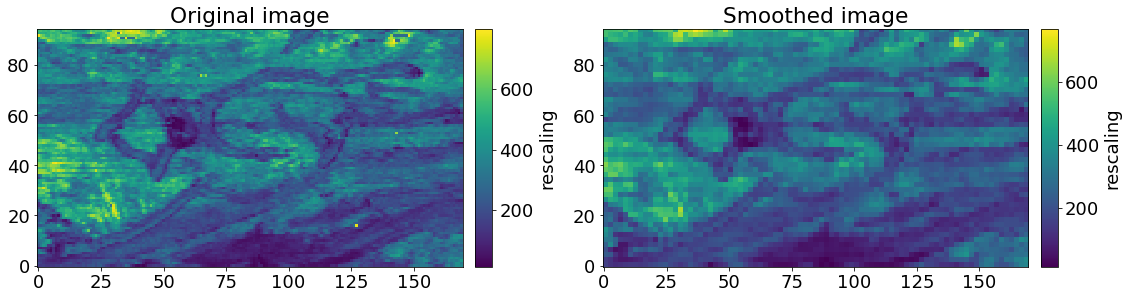

In [22]:
rcParams['font.size'] = 18

fig, axs = subplots(1, 2, figsize = (15, 6))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(data.rescaling.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_label('rescaling')
ax.set_title('Original image')

ax = axs[1]
im = ax.imshow(data_smooth.rescaling.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_label('rescaling')
ax.set_title('Smoothed image')

show()

### Refit primary phases on smoothed data

In [23]:
%%time

gm1 = GammaMap().from_data(data_smooth, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)
gm1 = gm1.search()
overlap_area_1 = gm1.overlap_area()

Using 8 CPUs
CPU times: user 19.1 s, sys: 1.79 s, total: 20.9 s
Wall time: 26.5 s


### Fit secondary phases on smoothed data

You can choose how many peaks to consider in secondary phases

In [24]:
%%time

first_n_peaks_secondary = 3

gm2 = GammaMap_Secondary().from_data(gm1, data_smooth, phases_secondary, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks_secondary)
gm2 = gm2.fit_cycle(steps = 6, gamma = True)
overlap_area_difference_ratio_2 = gm2.overlap_area_difference()

Using 8 CPUs
CPU times: user 22.6 s, sys: 4.35 s, total: 26.9 s
Wall time: 28.1 s


### Quantify phase presence

In [25]:
correction = data_smooth.rescaling**0.5
criterion_1 = overlap_area_1 * correction
criterion_2 = overlap_area_difference_ratio_2 * correction

# Plots

### Primary phases

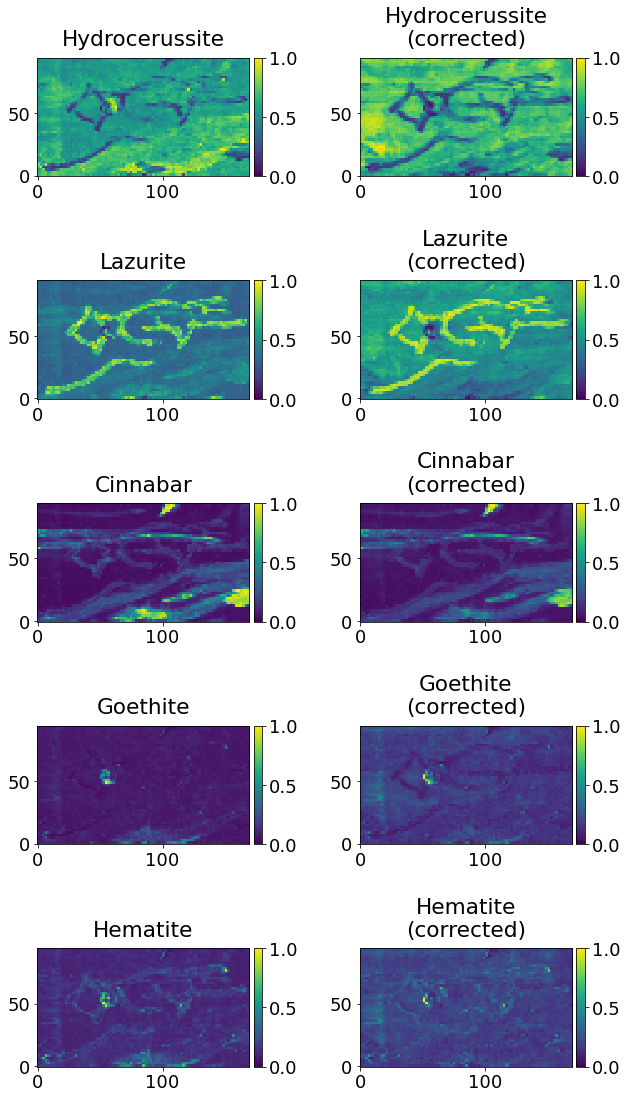

In [26]:
%matplotlib inline
rcParams['font.size'] = 18
settings_colorbar = [1.02, 0, 0.04, 1]
include_xrf_filter = False

if include_xrf_filter:
    n_cols = 4
else:
    n_cols = 2
fig, axs = subplots(len(gm1.phases), n_cols, figsize = (4.5 * n_cols, 3 * len(gm1.phases)))
fig.tight_layout(h_pad = 4, w_pad = 2)

for i, phase in enumerate(gm1.phases):
    if (len(gm1.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    matrix_plot = overlap_area_1[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label, y = 1.05)
    
    if (len(gm1.phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    matrix_plot = criterion_1[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label + '\n(corrected)', y = 1.05)
    
    if include_xrf_filter:
        indices_associated_elements = []
        if 'associated elements' in phase.keys():
            print(phase.label + ': ' + ', '.join(phase['associated elements']))
            for element in phase['associated elements']:
                j = find_element(element, data_xrf.metadata['labels'], allow_loose = False)
                if j is None:
                    print(phase.label + ': ' + phase['associated element'] + ' not found')
                else:
                    indices_associated_elements.append(j)
        if indices_associated_elements:

            if (len(gm1.phases) > 1):
                ax = axs[i, 2]
            else:
                ax = axs[2]
            map_xrf = data_xrf.labels[..., indices_associated_elements].min(axis = -1)
            im = ax.imshow(map_xrf, interpolation = 'none', vmin = 0, vmax = None)
            formatter = ScalarFormatter(useMathText = True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-2, 2))
            cb = colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar), format = formatter)
            cb.ax.yaxis.set_offset_position('left')
            ax.set_title('\n'.join([data_xrf.metadata['labels'][idx] for idx in indices_associated_elements]), y = 1.05)

            if (len(gm1.phases) > 1):
                ax = axs[i, 3]
            else:
                ax = axs[3]
            map_xrd = criterion_1[..., i] / criterion_1[..., i].max()
            map_xrf = map_xrf / map_xrf.max()
            map_xrd_corrected = map_xrd * map_xrf
            map_xrd_corrected /= map_xrd_corrected.max()
            im = ax.imshow(map_xrd_corrected, interpolation = 'none', vmin = 0)
            colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
            ax.set_title(phase.label + '\n(corrected and filtered)', y = 1.05)

show()

### Secondary phases

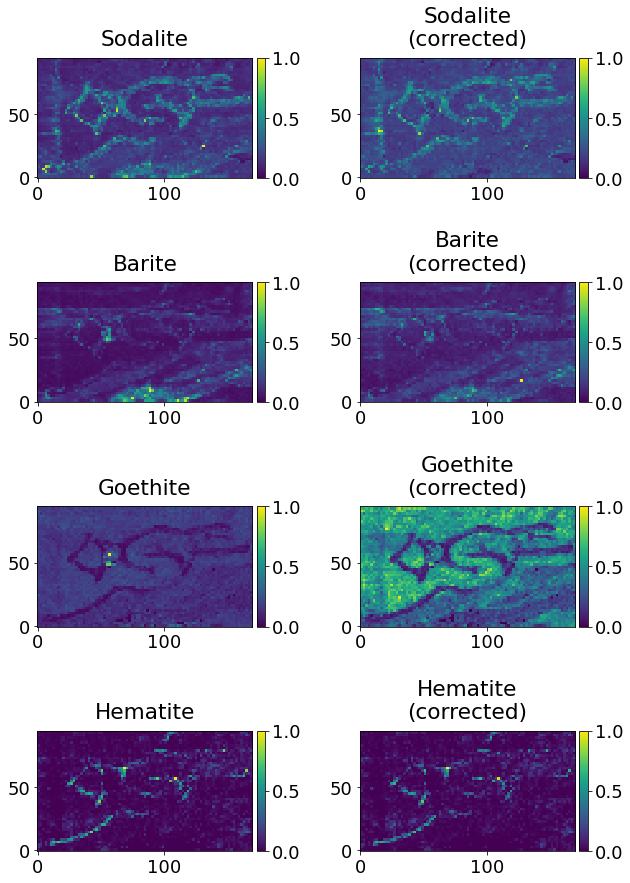

In [27]:
%matplotlib inline
rcParams['font.size'] = 18
settings_colorbar = [1.02, 0, 0.04, 1]
include_xrf_filter = False

if include_xrf_filter:
    n_cols = 4
else:
    n_cols = 2
fig, axs = subplots(len(gm2.phases), n_cols, figsize = (4.5 * n_cols, 3 * len(gm2.phases)))
fig.tight_layout(h_pad = 4, w_pad = 2)

for i, phase in enumerate(gm2.phases):
    if (len(gm2.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    matrix_plot = overlap_area_difference_ratio_2[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label, y = 1.05)
    
    if (len(gm2.phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    matrix_plot = criterion_2[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label + '\n(corrected)', y = 1.05)
    
    if include_xrf_filter:
        indices_associated_elements = []
        if 'associated elements' in phase.keys():
            print(phase.label + ': ' + ', '.join(phase['associated elements']))
            for element in phase['associated elements']:
                j = find_element(element, data_xrf.metadata['labels'], allow_loose = False)
                if j is None:
                    print(phase.label + ': ' + phase['associated element'] + ' not found')
                else:
                    indices_associated_elements.append(j)
        if indices_associated_elements:     

            if (len(gm2.phases) > 1):
                ax = axs[i, 2]
            else:
                ax = axs[2]
            map_xrf = data_xrf.labels[..., indices_associated_elements].min(axis = -1)
            im = ax.imshow(map_xrf, interpolation = 'none', vmin = 0, vmax = None)
            formatter = ScalarFormatter(useMathText = True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-2, 2))
            cb = colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar), format = formatter)
            cb.ax.yaxis.set_offset_position('left')
            ax.set_title('\n'.join([data_xrf.metadata['labels'][idx] for idx in indices_associated_elements]), y = 1.05)

            if (len(gm2.phases) > 1):
                ax = axs[i, 3]
            else:
                ax = axs[3]
            map_xrd = criterion_2[..., i] / criterion_2[..., i].max()
            map_xrf = map_xrf / map_xrf.max()
            map_xrd_corrected = map_xrd * map_xrf
            map_xrd_corrected /= map_xrd_corrected.max()
            im = ax.imshow(map_xrd_corrected, interpolation = 'none', vmin = 0)
            colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
            ax.set_title(phase.label + '\n(corrected and filtered)', y = 1.05)

show()

### Save maps of secondary phases as PNG and TIF

In [29]:
rcParams['font.size'] = 14

matrices_base = [overlap_area_difference_ratio_2, criterion_2]
string_added = ['', ' (corrected)']

for i in [0, 1]:
    matrix_base = matrices_base[i]
    value_max = nanmax(nanmax(matrix_base, axis = 0, keepdims = True), axis = 1, keepdims = True)
    matrix_plot = matrix_base / value_max
    matrix_components_tiff = flip((matrix_plot * 65535).astype('uint16'), axis = [0])

    for idx_phase, phase in enumerate(gm2.phases):
        fig, ax = subplots(figsize = (5, 3))
        im = imshow(matrix_plot[..., idx_phase], interpolation = 'none', vmin = 0)
        colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(phase.label)
        fig.set_dpi(80)
        savefig(path_figures + 'secondary - ' + phase.label + ' - presence' + string_added[i] + '.png',
                    bbox_inches = 'tight', dpi = 600)

        img = Image.fromarray(matrix_components_tiff[..., idx_phase])
        img.save(path_results + 'secondary - ' + phase.label + ' - presence BW' + string_added[i] + '.tiff')
        img.save(path_figures + 'secondary - ' + phase.label + ' - presence BW' + string_added[i] + '.png')

        close(fig)

# Explore phases in a pixel given by element selection

### List of phases

In [28]:
DataFrame({
    'Category': ['Primary'] * len(phases_primary) + ['Secondary'] * len(phases_secondary),
    'Phase': [p.label for p in phases_primary + phases_secondary],
    'Chemical formula': [p['_chemical_formula_sum'] if '_chemical_formula_sum' in p.keys() else '-' for p in phases_primary + phases_secondary]
})

,Category,Phase,Chemical formula
0,Primary,Hydrocerussite,C H O4 Pb1.5
1,Primary,Lazurite,Al2.97 Ca0.8 Mg0.36 Na3.12 O15.12 S Si3.03
2,Primary,Cinnabar,Hg S
3,Primary,Goethite,Co0.07 Fe0.93 H O2
4,Primary,Hematite,Fe2 O3
5,Secondary,Sodalite,C0.15 Al3 Ca0.616 Cl0.47 K0.7 Na2.64 O13.986 S...
6,Secondary,Barite,Ba O4 S
7,Secondary,Goethite,Co0.07 Fe0.93 H O2
8,Secondary,Hematite,Fe2 O3


### Exploration
The procedure selects the pixel where the first of `elements_allowed` has the maximum XRF intensity.

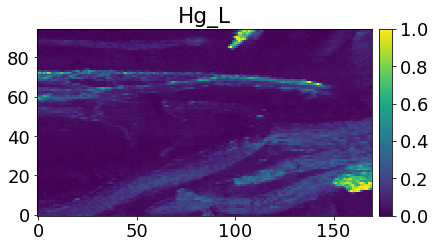

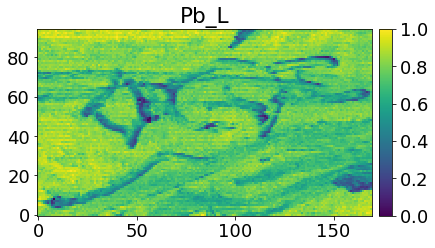

Threshold 0.400 applied to the following XRF maps: Hg_L, Pb_L.
Hg_L used to search for maximum.
Selected 232 pixels over 16150.
Chosen coordinates: (105, 89)


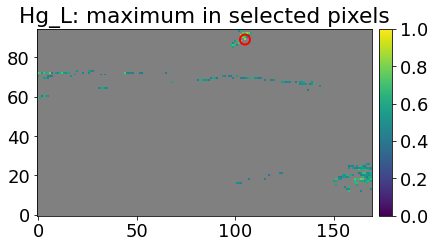

,Category,Phase,Overlap
0,Primary,Hydrocerussite,0.258
1,Primary,Cinnabar,0.441


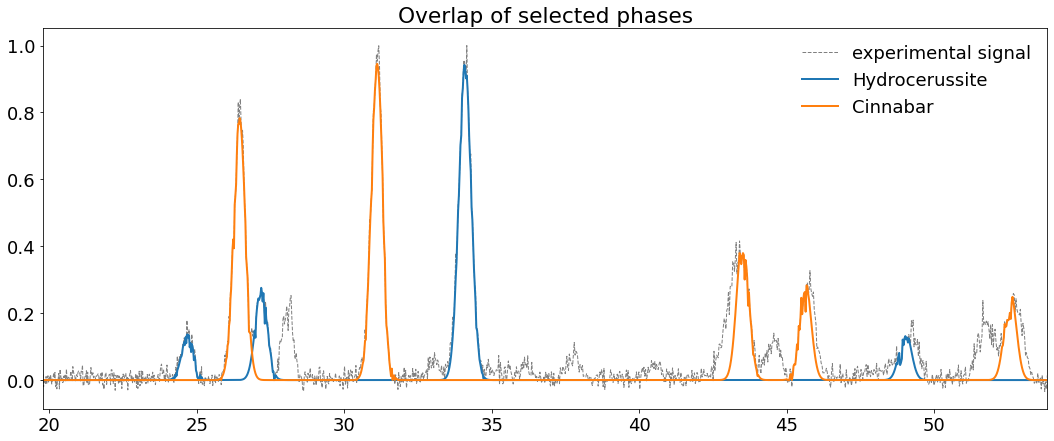

In [29]:
rcParams['font.size'] = 18

elements_allowed = ['Hg', 'Pb']
threshold_xrf = 0.4

indices_elements_allowed = []
for e in elements_allowed:
    i = find_element(e, data_xrf.metadata['labels'])
    if i is not None:
        indices_elements_allowed.append(i)
        fig, ax = subplots(figsize = (6, 4))
        im = ax.imshow(maps_xrf_norm[..., i], interpolation = 'none')
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_title(data_xrf.metadata['labels'][i])
        show()
    else:
        print("'" + e + "' not found among XRF phases.")
print(f'Threshold {threshold_xrf:.3f} applied to the following XRF maps: ' + ', '.join([data_xrf.metadata['labels'][i] for i in indices_elements_allowed]) + '.')
print(f'{data_xrf.metadata["labels"][indices_elements_allowed[0]]} used to search for maximum.')

coord_sel = zeros(data.shape[:2], bool)
for x in range(data.shape[1]):
    for y in range(data.shape[0]):
        if all(maps_xrf_norm[y, x, i] >= threshold_xrf for i in indices_elements_allowed):
            coord_sel[y, x] = True
print(f'Selected {coord_sel.sum()} pixels over {data.shape[0] * data.shape[1]}.')

map_xrf_selected = maps_xrf_norm[..., indices_elements_allowed[0]].copy()
map_xrf_selected[~coord_sel] = None
position = nanargmax(map_xrf_selected.flatten())
y, x = unravel_index(position, map_xrf_selected.shape)
print(f'Chosen coordinates: {(x, y)}')

cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')
fig, ax = subplots(figsize = (6, 4))
im = ax.imshow(map_xrf_selected, vmin = 0, vmax = 1, interpolation = 'none', cmap = cmap_viridis)
ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
formatter = ScalarFormatter(useMathText = True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
cb.ax.yaxis.set_offset_position('left')
ax.set_title(data_xrf.metadata['labels'][indices_elements_allowed[0]] + ': maximum in selected pixels')
show()

gs2 = gm2.get_pixel(x, y)

df_overlaps = DataFrame(columns = ['Category', 'Phase', 'Overlap'])
fig, ax = subplots(figsize = (18, 7))
theta = gs2.gammasearch_1[0].theta
ax.plot(theta, gs2.intensity, c = 'grey', ls = '--', lw = 1, label = 'experimental signal')
for j, phase in enumerate(gm2.primary_phases):
    if '_chemical_formula_sum' in phase:
        if any(e in phase['_chemical_formula_sum'] for e in elements_allowed):
            ax.plot(theta, gs2.gammasearch_1.overlap()[j], ls = '-', lw = 2, label = phase.label)
            df_overlaps.loc[len(df_overlaps)] = ['Primary', phase.label, gs2.gammasearch_1.overlap_area_ratio()[j]]
for j, phase in enumerate(gm2.phases):
    if '_chemical_formula_sum' in phase:
        if any(e in phase['_chemical_formula_sum'] for e in elements_allowed):
            ax.plot(theta, gs2.overlap()[j], ls = '-', lw = 2, label = phase.label)
            df_overlaps.loc[len(df_overlaps)] = ['Secondary', phase.label, gs2.overlap_area_difference_ratio()[j]]

display(df_overlaps.style.format({'Overlap': '{:.3f}'}))
legend(frameon = False)
ax.set_xlim(theta[0], theta[-1])
ax.set_title('Overlap of selected phases')
show()

### Overlap of each secondary phases vs all primary phases

Primary phases: 0.726 of experimental area
Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases
Sodalite:	0.005
Barite:	0.005
Goethite:	0.001
Hematite:	0.000


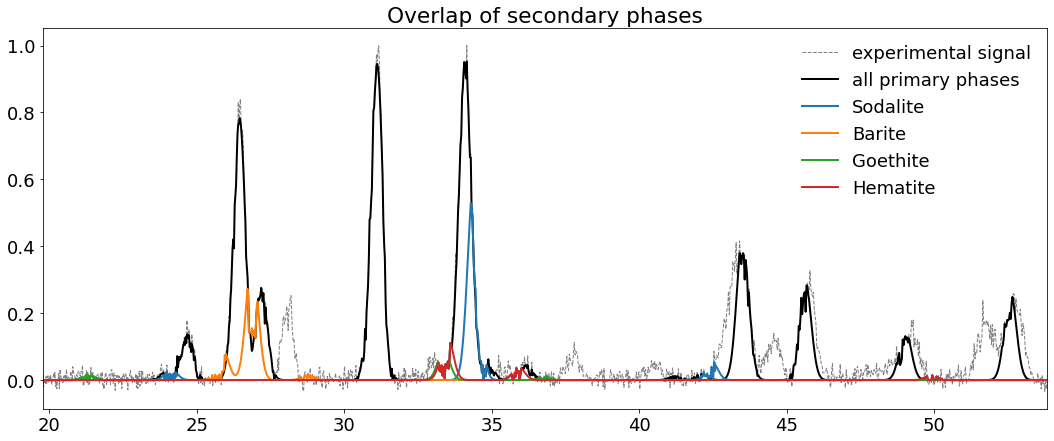

In [30]:
gs2 = gm2.get_pixel(x, y)

fig, ax = subplots(figsize = (18, 7))
theta = gs2.gammasearch_1[0].theta
ax.plot(theta, gs2.intensity, c = 'grey', ls = '--', lw = 1, label = 'experimental signal')
ax.plot(theta, gs2.gammasearch_1.overlap_total(), c = 'black', ls = '-', lw = 2, label = 'all primary phases')
print(f'Primary phases: {gs2.gammasearch_1.overlap_total_ratio():.3f} of experimental area')
print('Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases')
for j in range(len(gs2)):
    ax.plot(theta, gs2.overlap()[j], ls = '-', lw = 2, label = gs2[j].phase.label)
    print(f'{gs2[j].label}:\t{gs2.overlap_area_difference_ratio()[j]:.3f}')

legend(frameon = False)
ax.set_xlim(theta[0], theta[-1])
ax.set_title('Overlap of secondary phases')
show()